#### 1. **Importing the required libraries:**




In [1]:
import tensorflow as tf  ### TensorFlow and its Keras module for building and training neural networks.
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt  ### Matplotlib for visualizing images and plots.

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

#### **2. Loading the dataset:**

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Stationary",  #### load images from a directory.
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  #### takes parameters such as directory path, seed for shuffling, image size, and batch size.
    batch_size=BATCH_SIZE ###  ### The dataset is stored in the dataset variable.
)

Found 143 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names ## the different categories

['Eraser', 'Highlighter', 'Pen', 'Scale']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 1 0 0 0 1 0 0 2 0 3 1 0 2 1 1 1 1 0 2 2 2 0 1 0 3 1 1 2 1 1 2]


#### 3. **Displaying sample images:**

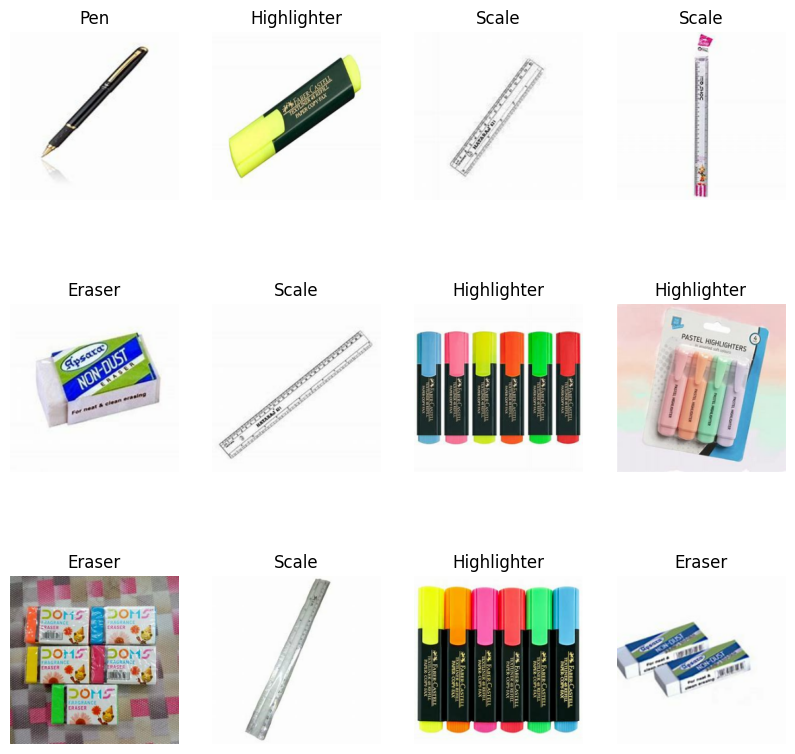

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

5

#### **4.Training Testing and Validation:**

In [8]:
train_size = 0.8
len(dataset)*train_size

4.0

In [9]:
train_ds = dataset.take(54)
len(train_ds)

5

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [11]:
val_size=0.1
len(dataset)*val_size

0.5

In [12]:
val_ds = test_ds.take(4)
len(val_ds)

0

In [13]:
test_ds = test_ds.skip(4)
len(test_ds)

0

#### 5. **Partitioning the dataset:**

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ### training, testing and validation dataset
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

4

In [17]:
len(val_ds)

0

In [18]:
len(test_ds)

1

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### 6. **Data augmentation:**

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


#### 7. **Model architecture:**

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

#### 8. **Model compilation:**

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


#### 9. **Model training:**

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
4/4 [==============================] - 20s 4s/step - loss: 1.7301 - accuracy: 0.2432
Epoch 2/20
4/4 [==============================] - 18s 5s/step - loss: 1.4882 - accuracy: 0.3063
Epoch 3/20
4/4 [==============================] - 18s 5s/step - loss: 1.4324 - accuracy: 0.2703
Epoch 4/20
4/4 [==============================] - 17s 4s/step - loss: 1.3896 - accuracy: 0.2973
Epoch 5/20
4/4 [==============================] - 17s 4s/step - loss: 1.3808 - accuracy: 0.3333
Epoch 6/20
4/4 [==============================] - 17s 5s/step - loss: 1.4195 - accuracy: 0.2162
Epoch 7/20
4/4 [==============================] - 17s 4s/step - loss: 1.3839 - accuracy: 0.2793
Epoch 8/20
4/4 [==============================] - 24s 6s/step - loss: 1.3463 - accuracy: 0.4505
Epoch 9/20
4/4 [==============================] - 17s 5s/step - loss: 1.3322 - accuracy: 0.3784
Epoch 10/20
4/4 [==============================] - 16s 4s/step - loss: 1.3266 - accuracy: 0.3333
Epoch 11/20
4/4 [======================

#### 10. **Model Evaluation:**

In [27]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 1.0388 - accuracy: 0.5625


In [28]:
scores

[1.0387792587280273, 0.5625]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 4}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

20

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7301069498062134,
 1.4881662130355835,
 1.432416319847107,
 1.3896015882492065,
 1.3808066844940186]

first image to predict
actual label: Highlighter
1/1 [==============================] - 1s 1s/step
predicted label: Pen


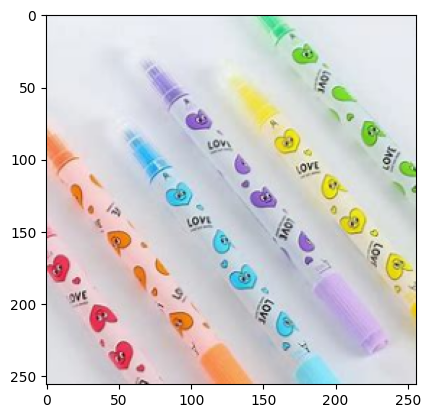

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8') #extracts the first image from the batch and converts it to a NumPy array.
    first_label = labels_batch[0].numpy() #retrieves the corresponding label for the first image in the batch.

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # converts the input image (in NumPy array format) to a TensorFlow tensor
    img_array = tf.expand_dims(img_array, 0) #reshapes the tensor to have a batch dimension of 1, as the model expects input in batch format.

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### 11. **Visualising Predictions:**

1/1 [==============================] - 0s 103ms/step


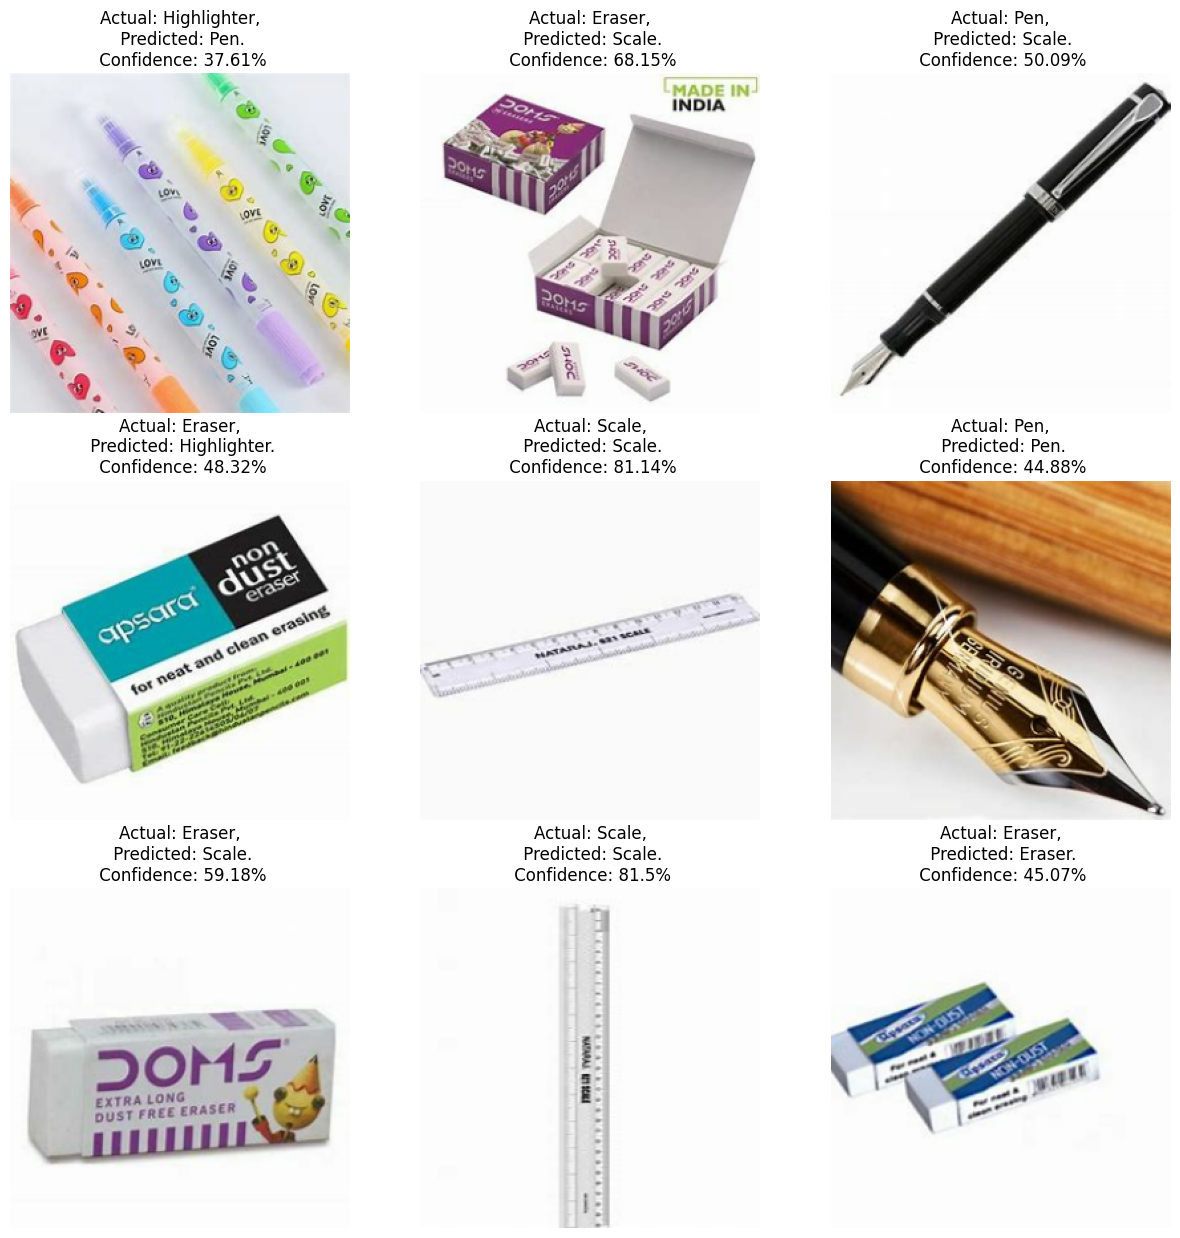

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] ### the actual class

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        ## predicted class
        plt.axis("off")

In [38]:
model.save('./models', save_format='tf')